# Concat json train full

In [ ]:
# !rm -r ./datasets/tsd/train/annotation
# !mkdir -p datasets/tsd/train/annotations/prep

In [1]:
from glob import glob
import mmcv
import os
import os.path as osp
import mmcv
from tqdm import tqdm
from pycocotools.coco import COCO


# Concat 

In [3]:

image_root_dir = 'datasets/tsd/train/train-images'
paths = glob('datasets/tsd/train/annotations-orig/**/*.json', recursive=True)

images = []
annotations = []

old_id_to_new_id = dict()


cats = None
prev_cats = None
for jpath in tqdm(paths):
    data = mmcv.load(jpath)
    cats = ";".join([_['name'] for _ in data['categories'][:10]])
    if prev_cats is not None:
        assert cats == prev_cats
    prev_cats = cats#";".join([_['name'] for _ in data['categories'][:10]])
    
    for image in data['images']:
        old_id = image['id']
        old_id_to_new_id[old_id] = len(images)
        image['id'] = old_id_to_new_id[old_id]
        dir_name = jpath.split('/')[-3]+'/images'
        image['file_name'] = dir_name+'/'+image['file_name']
        path = os.path.join(image_root_dir, image['file_name'])
        assert os.path.exists(path), path
        images.append(image)

    for ann in data['annotations']:
        ann['id'] = len(annotations) # update id
        ann['image_id'] = old_id_to_new_id[ann['image_id']] # update image id
        annotations.append(ann)


#     print(len(data['categories']))

data['images'] = images
data['annotations'] = annotations
data['categories'] = data['categories'][:10]
print(len(images))



mmcv.dump(data, 'datasets/tsd/train/annotations/prep/train-full-10-class.json')
print(len(paths))

100%|██████████| 614/614 [00:04<00:00, 135.76it/s]


59196
614


# Find mapping

In [4]:
train = COCO('./datasets/tsd/train/annotations/prep/train-full-10-class.json')
test = COCO('./datasets/tsd/test/test_data_20210524/test_traffic_sign_5k.json')

loading annotations into memory...
Done (t=3.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


## Find images in common

In [5]:
train_fn2im = dict()
def encode_filename_train(fn):
    a = fn.split('_')[0]
    b = fn.split('/')[-1]
    return a+'_'+b

for image in train.imgs.values():
    encoded_fn = encode_filename_train(image['file_name'])
    train_fn2im[encoded_fn]=image

In [6]:
test_fn2im = dict()
for image in test.imgs.values():
    fn = image['file_name']
    a = fn.split('_')[0]
    b = fn.split('_')[-2]
    c = fn.split('_')[-1]
    test_fn2im[a+'_'+b+'_'+c]=image

In [7]:
k_images = [k for k,image in test_fn2im.items() if k in train_fn2im]
len(k_images), 'in common'

(2946, 'in common')

In [8]:
from tqdm import tqdm
import torch
import numpy as np
from mmcv.ops import bbox_overlaps

def get_bbox(anns):
    bbox = np.array([ann['bbox'] for ann in anns])
    bbox[:,2] = bbox[:,2]+bbox[:,0]
    bbox[:,3] = bbox[:,3]+bbox[:,1]
    return torch.from_numpy(bbox.astype(np.float32)).cuda()


id_mappings = np.zeros([11, 6])

for k in tqdm(k_images):
    if k in ['542_1569028580_81774944.jpeg']: # TODO fix this bug
        continue
    train_image = train_fn2im[k]
    test_image = test_fn2im[k]
    train_ids_anns = train.getAnnIds(train_image['id'])
    test_ids_anns = test.getAnnIds(test_image['id'])
    train_anns = []
    test_anns = []
    
    for id in train_ids_anns:
        train_ann = train.anns[id]
        if train_ann['category_id'] in train.cats:
            train_ann['cat'] = train.cats[train_ann['category_id']]
            train_anns.append(train_ann)

    for id in test_ids_anns:
        test_ann = test.anns[id]
        if test_ann['category_id'] in test.cats:
            test_ann['cat'] = test.cats[test_ann['category_id']]
            test_anns.append(test_ann)
    
    assert len(train_anns) >= len(test_anns)
    if len(train_anns)*len(test_anns):
        train_bboxes = get_bbox(train_anns)
        test_bboxes = get_bbox(test_anns)
        mapping = np.where(bbox_overlaps(train_bboxes, test_bboxes).cpu().numpy() > 0.8)
        
        for train_id, test_id in zip(*mapping):
            train_ann = train_anns[train_id]
            test_ann = test_anns[test_id]
#             n = '{}_{}'.format(train_ann['category_id'], test_ann['category_id'])
            id_mappings[train_ann['category_id'], test_ann['category_id']] += 1
train_to_test_cat_id = dict(np.array(np.where(id_mappings)).transpose().tolist())

100%|██████████| 2946/2946 [00:05<00:00, 557.10it/s] 


In [10]:
id_mappings

array([[   0.,    0.,    0.,    0.,    0.,    0.],
       [ 512.,    0.,    0.,    0.,    0.,    0.],
       [1332.,    0.,    0.,    0.,    0.,    0.],
       [ 576.,    0.,    0.,    0.,    0.,    0.],
       [ 266.,    0.,    0.,    0.,    0.,    0.],
       [ 627.,    0.,    0.,    0.,    0.,    0.],
       [   0.,  433.,    0.,    0.,    0.,    0.],
       [   0.,    0.,  339.,    0.,    0.,    0.],
       [   0.,    0.,    0., 3575.,    0.,    0.],
       [   0.,    0.,    0.,    0.,  626.,    0.],
       [   0.,    0.,    0.,    0.,    0., 3007.]])

In [11]:
# looks gud?

In [12]:
train_to_test_cat_id

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 3, 9: 4, 10: 5}

# full 6 class

In [14]:
train_dataset = train.dataset.copy()
anns = []
images_not_train = []
for ann in train_dataset['annotations']:
    old_id = ann['category_id']
    if old_id in train_to_test_cat_id:
        ann['category_id'] = train_to_test_cat_id[old_id]
        anns.append(ann)
    
train_dataset['categories'] = test.dataset['categories']
train_dataset['annotations'] = anns

mmcv.dump(train_dataset, './datasets/tsd/train/annotations/prep/train-full-6-class.json')

# ignore test 6class

In [15]:
# k_images

In [16]:
train_dataset = mmcv.load('./datasets/tsd/train/annotations/prep/train-full-6-class.json')
images = []
for image in train_dataset['images'] :
    fn = image['file_name']
    a = fn.split('_')[0]
    b = fn.split('/')[-1]
    if not a+'_'+b in k_images:
        images.append(image)

        
print('Orig:', len(train_dataset['images']))
train_dataset['images'] = images
print('After Ignore:', len(train_dataset['images']))

mmcv.dump(train_dataset, './datasets/tsd/train/annotations/train-6class.json')

Orig: 59196
After Ignore: 56250


# Visualization

In [26]:
# pads

In [29]:
train = COCO('./datasets/tsd/train/annotations/train-6class.json')

loading annotations into memory...
Done (t=4.70s)
creating index...
index created!


(4, 2)


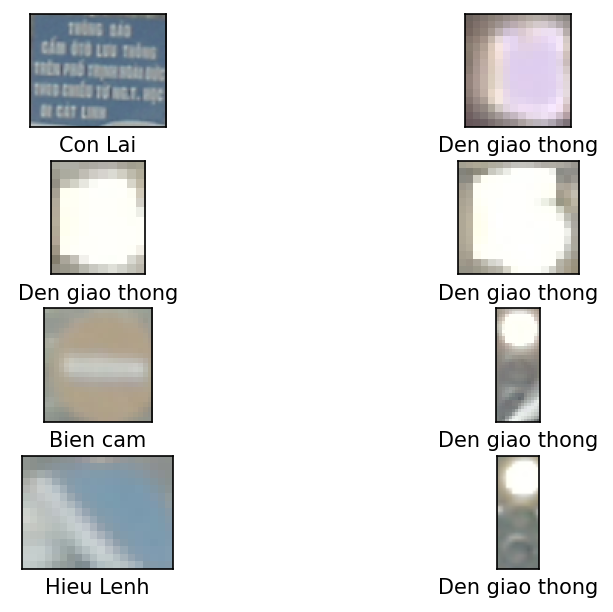

In [62]:
from avcv.visualize import *
import numpy as np


image = np.random.choice(list(train.imgs.values()))
img = './datasets/tsd/train/train-images/'+image['file_name']
anns = [train.anns[i] for i in train.getAnnIds(image['id'])]
pads = []
img = mmcv.imread(img, channel_order='rgb')
lbls = []
for ann in anns:
    x1,y1,w,h = [int(_) for _ in ann['bbox']]
    x2 = x1+w
    y2 = y1+h
    pad = img[y1:y2, x1:x2]
    pads.append(pad)
    cat_id = ann['category_id']
    lbls.append(train.cats[cat_id]['name'])
    
plot_images(pads, labels = lbls, dpi=150)
# img = mmcv.visualization.imshow_bboxes(img, bbox, show=False)
# show(img, dpi=100)

In [414]:
# from avcv.visualize import show
# import numpy as np
# img = './datasets/tsd/test/test_data_20210524/test_images_5k/'+test_image['file_name']
# print(test_image)
# bbox = np.array([ann['bbox'] for ann in test_anns])
# bbox[:,2] = bbox[:,2]+bbox[:,0]
# bbox[:,3] = bbox[:,3]+bbox[:,1]

# img = mmcv.visualization.imshow_bboxes(img, bbox, show=False)
# show(img, dpi=100)

# BDI YOLO TO COCO

In [46]:
img_paths = glob('/home/av/gitprojects/yolox/datasets/tsd/bdi/images/**/*.png')

In [47]:
# train_dataset['annotations'][0]

In [49]:
from PIL import Image
with_lbls = []
test = COCO('./datasets/tsd/test/test_data_20210524/test_traffic_sign_5k.json')
mapping_ann = {0: 2, 1: 1, 2: 3, 3: 5, 4: 0, 5: 4}

for dset in ['train', 'val', 'test']:
    anns = []
    images = []
    paths = [p for p in img_paths if dset in p]
    for image_id, img_path in tqdm(enumerate(paths), total=len(paths)):
        width, height = Image.open(img_path).size

        image = dict(
            id=image_id,
            width=width,
            height=height,
            file_name = os.path.basename(img_path)
        )
        images.append(image)

        lbl_path = img_path.replace('/images/', '/labels/').split('.')[0]+'.txt'

        with_lbls.append(osp.exists(lbl_path))
        if with_lbls[-1]:
            for ann in open(lbl_path).readlines():
                lbl, x,y,w,h = ann.split(' ')
                cat_id = mapping_ann[int(lbl)]
                x = float(x)*width
                y = float(y)*height
                w = float(w)*width
                h = float(h)*height

                ann_id = len(anns)
                ann_dict = {'id': ann_id,
                 'image_id': image_id,
                 'category_id': cat_id,
                 'segmentation': [],
                 'area': h*w,
                 'bbox': [cx,cy, w,h],
                 'iscrowd': 0,
                 'attributes': {'occluded': False}}
                anns.append(ann_dict)
    test_ds = test.dataset.copy()
    test_ds['images'] = images
    test_ds['annotations'] = anns
    mmcv.dump(test_ds, f'./datasets/tsd/bdi/labels/{dset}.json')

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


100%|██████████| 3388/3388 [00:00<00:00, 4380.61it/s]


# Visualize 

In [63]:
from avcv.visualize import show
import numpy as np
data = COCO('./datasets/tsd/bdi/labels/train.json')

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [64]:
class_names = [_['name'] for _ in data.cats.values()]

In [401]:
image

{'id': 22945,
 'width': 2880,
 'height': 2160,
 'file_name': '22945_2020_1125_123438_012_000030.jpg',
 'old_path': './datasets/tsd/bdi/images/train/2020_1125_123438_012_000030.png'}

In [419]:
def visualize(data, im_dir):
    im_id = np.random.choice(list(data.imgs.keys()))
    image = data.imgs[im_id]
    img = im_dir+image['file_name']
    class_names = [_['name'] for _ in data.cats.values()]
    test_anns = [data.anns[id] for id in data.getAnnIds(image['id'])]
    bbox = np.array([ann['bbox'] for ann in test_anns])
    lbls = np.array([ann['category_id'] for ann in test_anns])
    print('len(bbox): ', len(bbox))
    if len(bbox):
        print(bbox)
        img = mmcv.imread(img, channel_order='rgb')
        bbox[:,2] = bbox[:,2]+bbox[:,0]
        bbox[:,3] = bbox[:,3]+bbox[:,1]
        pads = []
        for box in bbox.astype(int):
            x1,y1,x2,y2 = box
            pads.append(img[y1:y2, x1:x2])
        img = mmcv.visualization.imshow_det_bboxes(img, bbox,lbls, class_names=class_names,show=False)[...,::-1]
        print(image)
        show(img, dpi=200)

In [350]:
bdi = COCO('./datasets/tsd/bdi/labels/test.json')


train = COCO('./datasets/tsd/vinai_bdi_combined/annotations/train.json')

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=5.91s)
creating index...
index created!


len(bbox):  1
[[1402.58  195.19   74.26   52.77]]
{'id': 24228, 'width': 1920, 'height': 1080, 'file_name': '24228_20371231_094920_000092.jpg', 'old_path': './datasets/tsd/bdi/images/train/20371231_094920_000092.png'}


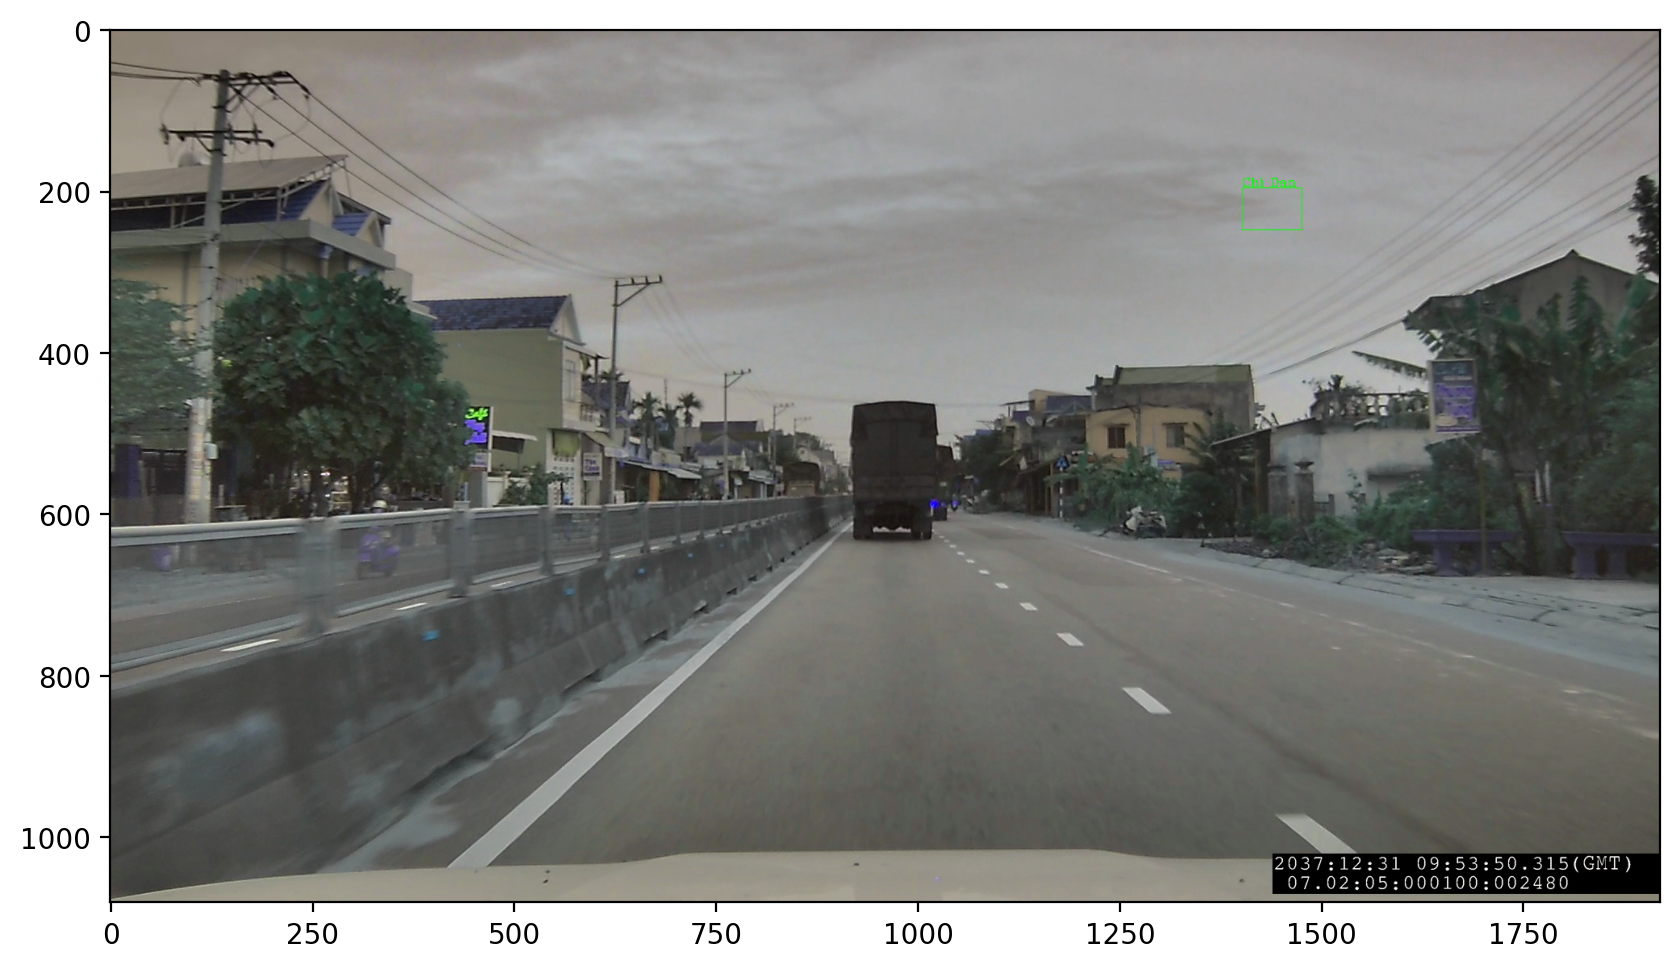

In [355]:
visualize(train, './datasets/tsd/vinai_bdi_combined/train-images/')

In [108]:
def f1(path):
    return '_'.join(path.split('_')[-3:])

file_name_test5k = {f1(im['file_name']):im for im in list(test5k.imgs.values()) if 'bdi' in im['file_name']}
file_names = {f1(im['file_name']):im for im in list(test_bdi.imgs.values())}

In [109]:
# file_name_test5k

In [110]:
k_names = set(file_names.keys()).intersection(set(file_name_test5k.keys()))

In [111]:
len(k_names)

2063

In [112]:
from tqdm import tqdm
import torch
import numpy as np
from mmcv.ops import bbox_overlaps

def get_bbox(anns):
    bbox = np.array([ann['bbox'] for ann in anns])
    bbox[:,2] = bbox[:,2]+bbox[:,0]
    bbox[:,3] = bbox[:,3]+bbox[:,1]
    return torch.from_numpy(bbox.astype(np.float32)).cuda()


def get_mapping(train, test, k_names):

    id_mappings = np.zeros([6, 6])

    for k in tqdm(k_names):
        train_image = file_names[k]
        test_image = file_name_test5k[k]
        train_ids_anns = train.getAnnIds(train_image['id'])
        test_ids_anns = test.getAnnIds(test_image['id'])
        train_anns = []
        test_anns = []

        for id in train_ids_anns:
            train_ann = train.anns[id]
            if train_ann['category_id'] in train.cats:
                train_ann['cat'] = train.cats[train_ann['category_id']]
                train_anns.append(train_ann)

        for id in test_ids_anns:
            test_ann = test.anns[id]
            if test_ann['category_id'] in test.cats:
                test_ann['cat'] = test.cats[test_ann['category_id']]
                test_anns.append(test_ann)

#         assert len(train_anns) >= len(test_anns)
        if len(train_anns)*len(test_anns):
            train_bboxes = get_bbox(train_anns)
            test_bboxes = get_bbox(test_anns)
            mapping = np.where(bbox_overlaps(train_bboxes, test_bboxes).cpu().numpy() > 0.8)

            for train_id, test_id in zip(*mapping):
                train_ann = train_anns[train_id]
                test_ann = test_anns[test_id]

                id_mappings[train_ann['category_id'], test_ann['category_id']] += 1
    train_to_test_cat_id = dict(np.array(np.where(id_mappings)).transpose().tolist())
    return train_to_test_cat_id, id_mappings

# Finally, concat train, val data

## Find mapping train-test

In [177]:

# train_paths = glob('./datasets/tsd/train/train-images/**/*.jpg', recursive=True)
# train_paths += glob('./datasets/tsd/train/train-images/**/*.jpeg', recursive=True)
# train_paths += glob('./datasets/tsd/train/train-images/**/*.png', recursive=True)
# train_paths += glob('./datasets/tsd/bdi/images/**/*.png', recursive=True)


# print(len(train_paths))

# train_paths += glob('./datasets/tsd/bdi/images/**/*.jpg', recursive=True)
# train_paths += glob('./datasets/tsd/bdi/images/**/*.jpeg', recursive=True)

# print(len(train_paths))

# # train_paths = glob('./datasets/tsd/test/test_data_20210524/test_images_5k/*')
# def f(path):
#     return mmcv.imread(path).sum()
# train_hashes = multi_thread(f, train_paths)

# # len(train_dict)

# train_dict = dict()

# for h,p in zip(train_hashes, train_paths):
#     try:
#         train_dict[h].append(p)
#     except:
#         train_dict[h] = [p]

# test_paths = glob('./datasets/tsd/test/test_data_20210524/test_images_5k/*')
# def f(path):
#     return mmcv.imread(path).sum()
# test_hashes = multi_thread(f, test_paths)

    



# test_dict = dict()

# for h,p in zip(test_hashes, test_paths):
#     try:
#         test_dict[h].append(p)
#     except:
#         test_dict[h] = [p]

# not_founds = []
# mapping = {}
# for h, test_ps in tqdm(test_dict.items()):
# #     if not h in train_dict:
#     for test_p, train_p in itertools.product(test_ps, train_dict[h]):
#         if (mmcv.imread(test_p) == mmcv.imread(train_p)).all():
#             mapping[test_p] =train_p
#             break


In [236]:
mapping = mmcv.load('/vinai-autopilot/traffic-sign/test_data_20210524/extract_train_test_mapping.json')

In [237]:
# mapping

In [449]:
new_root_dir = './datasets/tsd/vinai_bdi_combined/'
os.makedirs(new_root_dir+'images', exist_ok=1)
os.makedirs(new_root_dir+'annotations', exist_ok=1)

ignore_test_paths = set([osp.abspath(_) for _ in mapping.values()])

# osp.abspath('./datasets/tsd/bdi/images//train/20200811_072859_000235.png') == osp.abspath('./datasets/tsd/bdi/images/train/20200811_072859_000235.png')

def f(img_dir, json_path):
    global images, annotations, ignore_count
    data = COCO(json_path)
    for image in tqdm(data.imgs.values()):
        old_id = image['id']
        image = image.copy()
        anns = [data.anns[i] for i in data.getAnnIds(image['id'])]

        old_path =  osp.abspath(os.path.join(img_dir,image['file_name']))
        
        image['old_path'] = img_dir+image['file_name']
        
        if old_path in ignore_test_paths:
            ignore_test_paths.remove(old_path)
            continue
        
        new_im_id = len(images)
        image['id'] = new_im_id

        fn = osp.basename(old_path)
        
        bs = "{:05d}_".format(image['id'])+fn.split('.')[0]+'.jpg'
        new_path = new_root_dir+'images/'+bs
        image['file_name'] = bs
        
        images.append(image)

        for ann in anns:
            ann['image_id'] = image['id']
            ann['id'] = len(annotations)
            annotations.append(ann)
            


In [450]:
# img_dir = './datasets/tsd/bdi/images/train/'
ignore_count = 0
images = []
annotations = []
f('./datasets/tsd/bdi/images/train/', './datasets/tsd/bdi/labels/train.json')
f('./datasets/tsd/bdi/images/test/', './datasets/tsd/bdi/labels/test.json')
f('./datasets/tsd/bdi/images/val/', './datasets/tsd/bdi/labels/val.json')
f('./datasets/tsd/train/train-images/', './datasets/tsd/train/annotations/prep/train-full-6-class.json')


loading annotations into memory...
Done (t=1.49s)
creating index...
index created!


100%|██████████| 40891/40891 [00:01<00:00, 30717.77it/s]


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


100%|██████████| 3388/3388 [00:00<00:00, 30618.33it/s]


loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


100%|██████████| 5791/5791 [00:00<00:00, 27646.40it/s]


loading annotations into memory...
Done (t=7.62s)
creating index...
index created!


100%|██████████| 59196/59196 [00:02<00:00, 27809.56it/s]


In [451]:
# images[0]

In [452]:
def f(image):
    out = './datasets/tsd/vinai_bdi_combined/images/'+image['file_name']
    if osp.exists(out):
        return
    img = mmcv.imread(image['old_path'])
    mmcv.imwrite(img, out)
multi_thread(f, images);

Multi-thread Pipeline: 100%|██████████| 104258/104258 [00:07<00:00, 13361.61Samples/s]

Finished


In [455]:
data = dict(images=images, annotations=annotations, categories=mmcv.load('./datasets/tsd/vinai_bdi_combined/annotations/test.json')['categories'])

In [456]:
mmcv.dump(data, './datasets/tsd/vinai_bdi_combined/annotations/train.json')

In [464]:
data = COCO('./datasets/tsd/vinai_bdi_combined/annotations/train.json')
# data = COCO('./datasets/COCO/annotations/instances_train2017.json')

loading annotations into memory...
Done (t=6.84s)
creating index...
index created!


In [443]:
# paths = glob('./datasets/tsd/vinai_bdi_combined/images/*')
# len(paths)

In [ ]:
for i in range(100):
    visualize(data, './datasets/COCO/train2017/')

In [457]:
data['images'][0]

{'id': 0,
 'width': 1920,
 'height': 1080,
 'file_name': '00000_20201126_video4_001491.jpg',
 'old_path': './datasets/tsd/bdi/images/train/20201126_video4_001491.png'}

In [459]:
data['annotations'][-1]

{'id': 511785,
 'image_id': 104257,
 'category_id': 3,
 'segmentation': [],
 'area': 881.8432000000003,
 'bbox': [29.14, 216.68, 47.36, 18.62],
 'iscrowd': 0,
 'attributes': {'occluded': False}}

In [ ]:
len(data.anns)

511786